# Qiskit config

In [1]:
from qiskit import IBMQ, QuantumCircuit, ClassicalRegister, QuantumRegister, execute, Aer, transpile
from qiskit.test.mock import FakeMontreal, FakeMumbai

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research') # 'ibm-q'

backend_0  = Aer.get_backend('qasm_simulator') 
backend_1  = provider.get_backend('ibmq_qasm_simulator')
backend_2  = provider.get_backend('ibmq_santiago')
backend_3  = provider.get_backend('ibmq_manila')
backend_4  = provider.get_backend('ibmq_casablanca')
backend_5  = provider.get_backend('ibmq_jakarta')
backend_6  = FakeMontreal()
backend_7  = FakeMumbai()

shots      = 8192

In [5]:
"""
    Select the backends that will be compared.
"""
#backends = [ backend_0 ]
#backends = [ backend_0, backend_1 ]
#backends = [ backend_2, backend_3 ]
backends = [ backend_4, backend_5 ]
#backends = [ backend_6, backend_7 ]
#backends = [ backend_2, backend_3, backend_4, backend_5 ]

# Experiment procedures

In [6]:
from qclib.state_preparation.bidirectional.state_tree_preparation import Amplitude

import qclib.state_preparation.bidirectional as bd

def measurement(circuit, q, c):
    circuit.measure(q, c)

    job = execute(circuit, backend, shots=shots, optimization_level=3)
    
    counts = job.result().get_counts(circuit)
    v = sum(counts.values())
    
    counts2 = {}
    for m in range(2**len(q)):
        pattern = '{:0{}b}'.format(m, n)
        if pattern in counts:
            counts2[pattern] = counts[pattern]
        else:
            counts2[pattern] = 0.0
            
    return { key : value/v for (key, value) in counts2.items() }
    
def bidirectional_experiment(circuit, input_state, s=None):
    state = [Amplitude(i, a) for i, a in enumerate(input_state)]

    q_output, state_tree, angle_tree = bd.initialize(circuit, state, s)

    n = int(np.log2(len(input_state)))
    c = ClassicalRegister(n)
    circuit.barrier()
    circuit.add_register(c)

    return measurement(circuit, q_output, c)


# Experiment

In [7]:
import numpy as np

"""
    Random complex input vector.
"""
#n = 3
#N = 2**n
#rng = np.random.default_rng(42)
#input_state = ((1.0 - 0.01) * rng.random(N) + 0.01) + ((1.0 - 0.01) * rng.random(N) + 0.01) * 1j
#input_state = input_state/np.linalg.norm(input_state)
""""""
"""
    Fixed real 8- and 16-dim input vector.
"""
input_state = [np.sqrt(0.03), np.sqrt(0.06), np.sqrt(0.15), np.sqrt(0.05), np.sqrt(0.1), np.sqrt(0.3), np.sqrt(0.2), np.sqrt(0.11) ]
#input_state = [np.sqrt(0.01), np.sqrt(0.02), np.sqrt(0.04), np.sqrt(0.02), np.sqrt(0.07), np.sqrt(0.08), np.sqrt(0.04), np.sqrt(0.01), np.sqrt(0.08), np.sqrt(0.02), np.sqrt(0.21), np.sqrt(0.09), np.sqrt(0.12), np.sqrt(0.08), np.sqrt(0.05), np.sqrt(0.06) ]
N = len(input_state)
n = int(np.log2(N))
""""""

print('n =', n)

ideal = np.power(np.abs(input_state),2)
print('\nInput vector probabilities (|x|^2):')
print({'{:0{}b}'.format(p, n) : a for p, a in enumerate(ideal)})

maes  = {}
probs = {}
for s in range(1, n+1):
    print('\ns =', s)
    backend_probs = {}
    backend_maes = {}
    for j, backend in enumerate(backends):
        backend_name = backend.name()
        backend_config = backend.configuration()
        backend_qubits = backend_config.n_qubits

        backend_probs[backend_name] = []

        print('\n\tExperiments using {0} backend, with {1} qubits available.'.format(backend_name, backend_qubits))

        for k in range(10):
            print('\tIter:', k)
            circuit = QuantumCircuit()
            prob = bidirectional_experiment(circuit, input_state, s)
            backend_probs[backend_name].append([val for key, val in prob.items()])
            print('\t', dict(sorted(prob.items())) )

        backend_maes[backend_name] = np.sum(np.abs(np.mean(backend_probs[backend_name],axis=0)-ideal))/len(ideal)
        
    probs[s] = backend_probs
    maes[s]  = backend_maes


n = 3

Input vector probabilities (|x|^2):
{'000': 0.03, '001': 0.06, '010': 0.15000000000000002, '011': 0.049999999999999996, '100': 0.1, '101': 0.29999999999999993, '110': 0.19999999999999998, '111': 0.10999999999999999}

s = 1

	Experiments using ibmq_casablanca backend, with 7 qubits available.
	Iter: 0
	 {'000': 0.1336669921875, '001': 0.14013671875, '010': 0.10693359375, '011': 0.1297607421875, '100': 0.1268310546875, '101': 0.134765625, '110': 0.1148681640625, '111': 0.113037109375}
	Iter: 1
	 {'000': 0.1334228515625, '001': 0.1351318359375, '010': 0.1260986328125, '011': 0.11767578125, '100': 0.138916015625, '101': 0.11767578125, '110': 0.1217041015625, '111': 0.109375}
	Iter: 2
	 {'000': 0.0872802734375, '001': 0.105224609375, '010': 0.0947265625, '011': 0.096923828125, '100': 0.16015625, '101': 0.1507568359375, '110': 0.1561279296875, '111': 0.1488037109375}
	Iter: 3
	 {'000': 0.089599609375, '001': 0.0963134765625, '010': 0.0867919921875, '011': 0.1005859375, '100': 0.161376

	 {'000': 0.06201171875, '001': 0.086669921875, '010': 0.1951904296875, '011': 0.0604248046875, '100': 0.11962890625, '101': 0.2701416015625, '110': 0.100830078125, '111': 0.1051025390625}
	Iter: 1
	 {'000': 0.0458984375, '001': 0.1060791015625, '010': 0.1453857421875, '011': 0.0423583984375, '100': 0.1075439453125, '101': 0.2882080078125, '110': 0.1663818359375, '111': 0.09814453125}
	Iter: 2
	 {'000': 0.0465087890625, '001': 0.102294921875, '010': 0.1351318359375, '011': 0.0455322265625, '100': 0.1046142578125, '101': 0.271240234375, '110': 0.1864013671875, '111': 0.1082763671875}
	Iter: 3
	 {'000': 0.0421142578125, '001': 0.10107421875, '010': 0.1402587890625, '011': 0.0438232421875, '100': 0.1065673828125, '101': 0.290283203125, '110': 0.17333984375, '111': 0.1025390625}
	Iter: 4
	 {'000': 0.0491943359375, '001': 0.110595703125, '010': 0.145751953125, '011': 0.0450439453125, '100': 0.0955810546875, '101': 0.2916259765625, '110': 0.159912109375, '111': 0.102294921875}
	Iter: 5
	 {'0

# Mean Absolute Error

In [8]:
for s, s_mae in maes.items():
    print('s = {0}'.format(s))
    for backend, mae in dict(sorted(s_mae.items(), key=lambda item: item[1])).items():
        print('\t{0} : MAE = {1}'.format(backend, mae))

s = 1
	ibmq_jakarta : MAE = 0.059414672851562496
	ibmq_casablanca : MAE = 0.070880126953125
s = 2
	ibmq_jakarta : MAE = 0.04972839355468749
	ibmq_casablanca : MAE = 0.0691259765625
s = 3
	ibmq_casablanca : MAE = 0.02129882812499998
	ibmq_jakarta : MAE = 0.028909301757812512


# Chart Data

In [9]:
for s, s_probs in probs.items():
    print('s = {0}'.format(s))
    for backend, backend_probs in s_probs.items():
        print('\t{0}'.format(backend))
        print('\t{0}'.format(str(np.mean(backend_probs, axis=0)).replace(' ', '\t')))

s = 1
	ibmq_casablanca
	[0.12878418	0.12924805	0.10552979	0.11036377	0.14702148	0.14277344
	0.11817627	0.11810303]
	ibmq_jakarta
	[0.09643555	0.09539795	0.10775146	0.10187988	0.15986328	0.1637207
	0.14086914	0.13408203]
s = 2
	ibmq_casablanca
	[0.15235596	0.12473145	0.1480957		0.12296143	0.11645508	0.1223999
	0.10515137	0.10784912]
	ibmq_jakarta
	[0.10698242	0.0755249		0.12058105	0.07122803	0.17005615	0.18793945
	0.14256592	0.12512207]
s = 3
	ibmq_casablanca
	[0.05284424	0.10313721	0.15565186	0.05360107	0.10996094	0.27209473
	0.15319824	0.09951172]
	ibmq_jakarta
	[0.05766602	0.08244629	0.08532715	0.03809814	0.13041992	0.32175293
	0.1609375		0.12335205]


# Plot Charts

s = 1


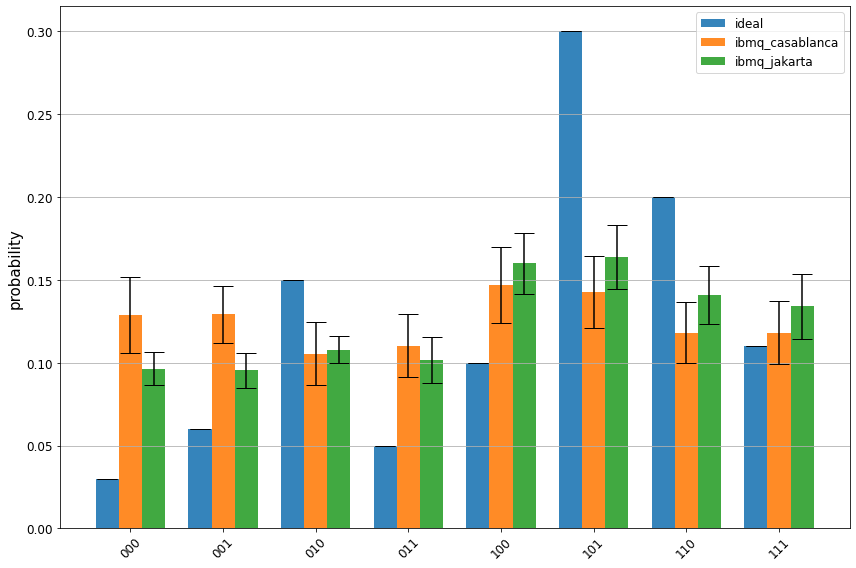

s = 2


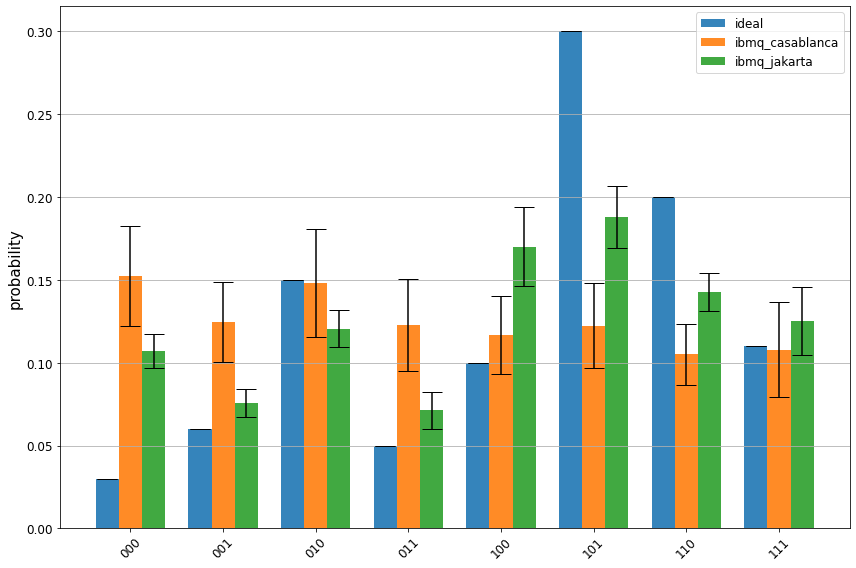

s = 3


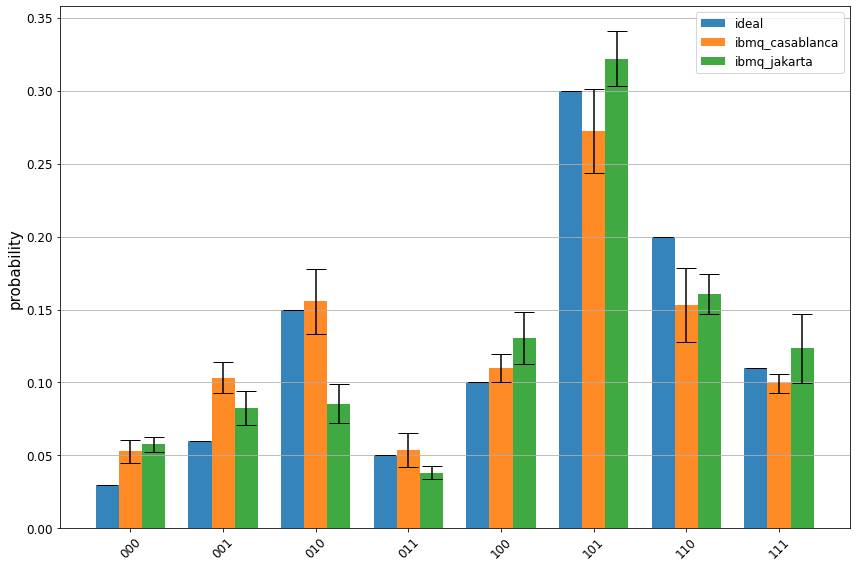

In [10]:
import numpy as np
import matplotlib.pyplot as plt
    
def plot(labels, averages, stds, xticks):
    n_bars = len(xticks)
    n_labels = len(labels)
    
    b_width = (1/n_labels)*0.75
    fig = plt.subplots(figsize = (12, 8))

    x_pos = np.arange(n_bars)
    for i, avg in enumerate(averages):
        plt.bar(x_pos, avg, yerr = stds[i], width = b_width, label = labels[i],
                align='center', alpha=0.9, ecolor='black', capsize=b_width*40)
        
        x_pos = [x + b_width for x in x_pos]
    
    plt.ylabel('probability', fontsize = 15)
    plt.xticks([x + b_width*(n_labels-1)/2 for x in range(n_bars)], xticks, fontsize=12, rotation=45)
    plt.grid(b=True, axis='y')
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()
    #plt.savefig('bar_plot_with_error_bars.png')
    plt.show()

def plot_result(ideal, probs):
    labels   = [ key for key, val in probs.items() ]
    averages = [ np.mean(prob, axis=0) for key, prob in probs.items() ]
    stds     = [ np.std(prob , axis=0) for key, prob in probs.items() ]
    xticks   = ['{:0{}b}'.format(p, n) for p, a in enumerate(input_state)]

    labels.insert(0, 'ideal')
    averages.insert(0, ideal)
    stds.insert(0, [0]*len(ideal))

    plot(labels, averages, stds, xticks)

for s in range(1, n+1):
    print('s =', s)
    plot_result(ideal, probs[s])